In [19]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [20]:
def smoothen(waypoints):
    optimumpointlist = []
    i = 0
    range_factor = 6
    avg_factor = 2 * range_factor + 1
    num_of_waypoints = len(waypoints)

    for point in waypoints:
        counter = 0
        estimated_x_cord = point[0]
        estimated_y_cord = point[1]
        while counter < range_factor:
            estimated_x_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][0]
            estimated_x_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][0]

            estimated_y_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][1]
            estimated_y_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][1]
            counter += 1

        estimated_x_cord = estimated_x_cord / avg_factor
        estimated_y_cord = estimated_y_cord / avg_factor


        optimumpointlist.append(np.array( (estimated_x_cord, estimated_y_cord) ))

        i += 1
    return np.array(optimumpointlist)

In [21]:
def calc_distance(prev_point, next_point):
    delta_x = next_point[0] - prev_point[0]
    delta_y = next_point[1] - prev_point[1]
    return math.hypot(delta_x, delta_y)

def smooth_central_line(center_line, max_offset, pp=0.10, p=0.05, c=0.70, n=0.05, nn=0.10, iterations=72, skip_step=1):
    if max_offset < 0.0001:
        return center_line
    if skip_step < 1:
        skip_step = 1
    smoothed_line = center_line
    for i in range(0, iterations):
        smoothed_line = smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step)
    return smoothed_line


def smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step):
    length = len(center_line)
    new_line = [[0.0 for _ in range(2)] for _ in range(length)]
    for i in range(0, length):
        wpp = smoothed_line[(i - 2 * skip_step + length) % length]
        wp = smoothed_line[(i - skip_step + length) % length]
        wc = smoothed_line[i]
        wn = smoothed_line[(i + skip_step) % length]
        wnn = smoothed_line[(i + 2 * skip_step) % length]
        new_line[i][0] = pp * wpp[0] + p * wp[0] + c * wc[0] + n * wn[0] + nn * wnn[0]
        new_line[i][1] = pp * wpp[1] + p * wp[1] + c * wc[1] + n * wn[1] + nn * wnn[1]
        while calc_distance(new_line[i], center_line[i]) >= max_offset:
            new_line[i][0] = (0.98 * new_line[i][0]) + (0.02 * center_line[i][0])
            new_line[i][1] = (0.98 * new_line[i][1]) + (0.02 * center_line[i][1])
    return new_line

In [22]:
TRACK_NAME = 'C:/Users/suraj/projects/deepracer24/2022_may_open_ccw.npy'

# Load the center, inner, outer waypoints
waypoints = np.load(TRACK_NAME)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [23]:
1.066*0.6*0.5

0.31980000000000003

In [24]:
# smooth_path = smoothen(center_line)
smooth_path = smooth_central_line( center_line, 1.066*0.45*0.5,skip_step=1 )
smooth_path_45 = smooth_central_line( center_line, 1.066*0.45*0.5,skip_step=1 )
smooth_path = np.array( [ np.array(point) for point in smooth_path ] )
smooth_path_45 = np.array( [ np.array(point) for point in smooth_path_45 ] )
# smooth_path = up_sample(smooth_path, 10)

In [25]:
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]

def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead

In [26]:
# optimal_speeds, tp, angleChange = optimalSpeed()
optimal_velocity_ = optimal_velocity(smooth_path, 1.25, 4.0, 5 )

Constant multiple for optimal speed: 1.452221318223697


In [27]:
import pandas as pd

data = pd.read_csv('C:/Users/suraj/projects/deepracer24/deepracer-log-guru/033/training_data.csv')
status_col = 'episode_status' if 'episode_status' in data.columns else 'status'
data = data[data[status_col].isin(['in_progress', 'on_track'])]
data.rename(columns={'X':'x', 'Y':'y', 'yaw':'heading', 'steer':'steering_angle', 'throttle':'speed', 'closest_waypoint': 'closest_waypoints'}, inplace=True)
data['is_offtrack'] = ~data['on_track']
data['is_crashed'] = False
data = data[['x', 'y', 'heading', 'speed', 'steering_angle', 'progress', 'closest_waypoints', 'steps', 'is_offtrack', 'is_crashed']]
data.shape

(33717, 10)

In [28]:
def get_params(row_number):
    params = data.iloc[row_number].to_dict()
    params['closest_waypoints'] = [ params['closest_waypoints'], params['closest_waypoints']+1 ]
    # print(params)

    params['waypoints'] = list( [list(point) for point in center_line] )
    params['track_width'] = 1.067
    params['is_reversed'] = False

    return params

In [29]:
from reward_function_001 import reward_function as reward_function_base
from reward_function import reward_function as reward_function_new

In [30]:
params = get_params(8008)
print(params)
print('base', '-'*10)
print( reward_function_base( params ) )
print('new', '-'*10)
print( reward_function_new( params ) )

{'x': 0.9771, 'y': 0.1974, 'heading': -40.1942, 'speed': 2.1, 'steering_angle': -15, 'progress': 4.9343, 'closest_waypoints': [70, 71], 'steps': 17, 'is_offtrack': False, 'is_crashed': False, 'waypoints': [[5.047713151170359, 0.7338535442132044], [5.04770565032959, 0.8638535439968109], [5.0476956834520985, 0.9938535436147392], [5.047682523727417, 1.1654984951019287], [5.047635078430176, 1.4671425223350525], [5.047637939453125, 1.7687879800796509], [5.047791957855225, 2.0704389810562134], [5.047592401504517, 2.3720779418945312], [5.046535491943359, 2.6736875772476196], [5.047996997833252, 2.9753825664520264], [5.054185152053833, 3.2772375345230103], [5.043642044067383, 3.578518033027649], [4.985517501831055, 3.873627543449402], [4.864901304244995, 4.149420976638794], [4.694380521774292, 4.397387504577637], [4.485466480255127, 4.614418983459473], [4.248257637023926, 4.800158500671387], [3.9890859127044678, 4.953978538513184], [3.7155709266662598, 5.080641984939575], [3.430908441543579, 5

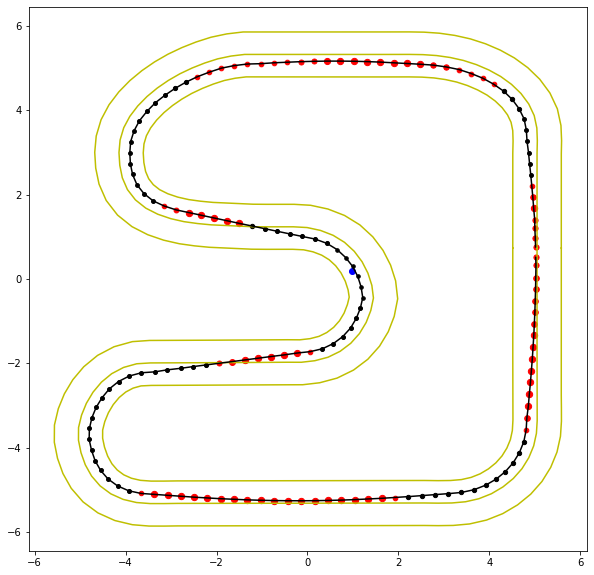

In [31]:
target = [-1.2972613775941606, -1.908002357052378]
plt.scatter(params['x'], params['y'], c = 'b')


plt.plot(center_line[:,0], center_line[:,1], label = 'outer_border', c = 'y')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'outer_border', c = 'k')
for i, point in enumerate(smooth_path):
    point = list(point)        
    plt.scatter(point[0], point[1], s = optimal_velocity_[i]*10, c = 'k' if optimal_velocity_[i]<2 else 'r')

# plt.scatter(target[0], target[1], c = 'g', s = 5)

plt.show()


In [32]:
base = []
new = []
for i in random.sample(range(0, len(data)), 1500):
    params = get_params(i)
    base.append( reward_function_base( params ) )
    new.append( reward_function_new( params ) )
    if i%50 == 0:
        print(i, ' rows done')
compare_df = pd.DataFrame({'base':base, 'new':new})
compare_df

steering_reward: 7.67479621988385 distance_reward: 9.747515071020082 speed_reward : 12.75 total: 30.172311290903934
steering_reward: 9.55392022902182 distance_reward: 8.463988971793075 speed_reward : 2.4665989944523425 total: 29.42177867567597
steering_reward: 18.9201830474305 distance_reward: 8.807166960893703 speed_reward : 0 total: 27.7273500083242
steering_reward: 9.973473159184369 distance_reward: 7.527591925759327 speed_reward : 0.37036944444444453 total: 27.7523153274614
steering_reward: 0.01 distance_reward: 4.818000427704412 speed_reward : 0 total: 4.828000427704412
steering_reward: 9.327739767620837 distance_reward: 3.999327458485107 speed_reward : 6.1532412485378005 total: 27.269737930130134
steering_reward: 15.234523163459206 distance_reward: 7.638136727882512 speed_reward : 0 total: 22.87265989134172
steering_reward: 9.916497961694139 distance_reward: 7.819194258970104 speed_reward : 7.7575187158112175 total: 33.470329219216794
steering_reward: 13.735953237832527 distance_

,base,new
0,30.172311,29.421779
1,27.727350,27.752315
2,4.828000,27.269738
3,22.872660,33.470329
4,19.830943,30.773105
...,...,...
1495,22.056350,27.874445
1496,44.947095,28.196460
1497,23.668069,28.264417
1498,56.089866,35.768978


In [33]:
compare_df['diff'] = compare_df['base'] - compare_df['new']

In [34]:
compare_df.describe()

,base,new,diff
count,1500.000000,1500.000000,1500.000000
mean,20.529537,25.464336,-4.934799
std,13.914399,10.956552,10.417693
min,-1.000000,-1.500000,-26.946338
25%,11.264241,26.169069,-11.675592
50%,21.936229,29.205532,-5.817719
75%,27.053371,31.286553,0.500000
max,59.610397,37.298784,30.842716


In [14]:
def normalize_reward(reward):
    old_value = reward
    old_min = 0.17
    old_max = 2.5
    new_min = -1
    new_max = 1
    new_value = ( (old_value - old_min) / float(old_max - old_min) ) * (new_max - new_min) + new_min
    return new_value

# rs = [normalize_reward(r) for r in compare_df['new'].tolist()]
normalize_reward(3.5)

1.8583690987124464

In [15]:
from reward_function import reward_function, get_heading_reward, is_higher_speed_favorable, following_smooth_path_reward, get_steering_reward

print( 'total rewards: ', reward_function(params) )
print( 'heading_reward', get_heading_reward(params) ) # 0.01 to 10
print('steering_angle_factor: ', get_steering_reward(params))
print( 'speed_reward', is_higher_speed_favorable(params) ) # 1 to 10
print( 'on_smooth_track_reward', following_smooth_path_reward(params) ) # 0 to 10

ImportError: cannot import name 'get_heading_reward' from 'reward_function' (c:\Users\suraj\projects\deepracer24\deepracer-on-the-spot\custom-files\reward_function.py)

In [ ]:
def optimalSpeed():
    """ no high difference in heading
        output range: 1 - 10
    """
    tp, angleChange = get_turn_points(smooth_path)
    tp = list([list(p) for p in tp])
    optimal_speeds = []
    max_speed = 3.8
    min_speed = 1.25
    for i, point in enumerate(smooth_path[:-1]):
        point = list(smooth_path[i+1])
        turn_angle = 0 if not point in tp else angleChange[ tp.index(point) ]
        optimal_speed = max_speed - ( turn_angle / max(angleChange)) * (max_speed - min_speed)
        optimal_speeds.append( optimal_speed )
    return optimal_speeds, tp, angleChange

In [ ]:
# optimal_velocity = optimal_velocity(smooth_path, 1.25, 3.8, 5)

In [ ]:
def calculate_angle(p1, p2, p3):
    # Calculate the angle between three points p1, p2, p3
    angle = math.degrees(
        math.atan2(p3[1] - p2[1], p3[0] - p2[0]) - math.atan2(p1[1] - p2[1], p1[0] - p2[0])
    )
    return angle % 360

def get_turn_points(coordinates):
    turn_points = []
    angle_change = []
    window_size = 8
    threshold_angle = 4.5  # Set a threshold angle to determine a significant turn

    for i in range(len(coordinates) - window_size + 1):
        window = coordinates[i : i + window_size]
        angles = [
            calculate_angle(window[j], window[j + 1], window[j + 2]) for j in range(window_size - 2)
        ]
        max_angle_change = abs( max(angles) - min(angles) )
        if max_angle_change >= threshold_angle:
            turn_points.append(coordinates[i])
            angle_change.append(abs(max_angle_change))
    return turn_points, angle_change

In [ ]:
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'center_line', c = 'y')
# plt.plot(inner_border[:,0], inner_border[:,1], label = 'inner_border', c = 'b')
# plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'b')
# plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'r')
# plt.plot(smooth_path[10:12,0], smooth_path[10:12,1], label = 'smooth_path_subsection', c = 'k')
# for i in range(0, 21):
#     plt.scatter( center_line[i][0], center_line[i][1], label = 'p_{}'.format(i), s = 10, c = 'k' )
#plt.scatter( center_line[10][0]+0.4, center_line[10][1], label = 'random_point', s = 10, c = 'k' )

for p in get_turn_points(smooth_path)[0]:
    plt.scatter( p[0], p[1], s = 10, c = 'k' )

plt.legend()
plt.show()

In [ ]:
for d in range(-2000, 2000, 10):
    d = d/100
    plt.scatter( d, 1/( (1+float(abs(d)/float(40))) ), c = 'k' )
plt.show()

In [ ]:
def is_a_turn_coming_up( params ):
    waypoints = _get_waypoints(params)
    next_way_point = waypoints[params["closest_waypoints"][1]] #getting smooth point at the index of the closest waypoint
    tp, ac = get_turn_points( waypoints )
    if next_way_point in tp:
        return ac[ tp.index(next_way_point) ]
    return 0

In [ ]:
( 1 + 0.01 + 1 + 0 )**2 /100

In [69]:
y = lambda x: max(1e-3, 1 - (x/(1.067*0.5)))

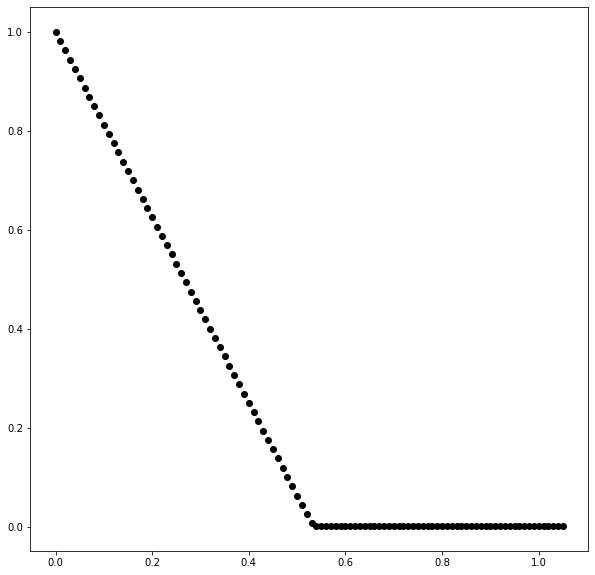

In [70]:
for i in range(0, 106):
    x = i/100
    plt.scatter(x, y(x),c='k')
    # plt.scatter(x, 1 - abs(x/60), c='b')
plt.show()

In [48]:
# print(max(1-abs(0.8), 1e-3))
y(1)

0.0

In [29]:
from reward_function_001 import get_closest_waypoints_for_optimized_waypoints
# smooth_path = list([ list(p) for p in smooth_path ])

ImportError: cannot import name 'get_closest_waypoints_for_optimized_waypoints' from 'reward_function_001' (c:\Users\suraj\projects\deepracer24\deepracer-on-the-spot\custom-files\reward_function_001.py)

In [ ]:
print(x)
y(0.9)

2.49


0.2770083102493075

In [ ]:
sp = Path(center_line).get()

In [ ]:
prev, nex = get_closest_waypoints_for_optimized_waypoints(sp, params)
prev = sp[prev]
nex =sp[nex]

In [ ]:
plt.scatter(params['x'], params['y'], c = 'k')
plt.scatter(prev[0], prev[1], c = 'b')
plt.scatter(nex[0], nex[1], c = 'r')
plt.show()

In [ ]:
from reward_function_002 import Path

In [ ]:
closest = Path(center_line).closest((params['x'], params['y']), 2)

In [ ]:
plt.scatter(params['x'], params['y'], c = 'k')
plt.scatter(closest[0][0], closest[0][1], c = 'b')
plt.scatter(closest[1][0], closest[1][1], c = 'r')
plt.show()

In [ ]:
prev_point = prev
next_point = nex
try:
    dist_cal_sim = (next_point[0] - prev_point[0]) / (next_point[1] - prev_point[1])
except:
    dist_cal_sim = 1
distance_from_racing_line = abs(params['x'] - dist_cal_sim * params['y'] + dist_cal_sim * next_point[1] - next_point[0]) / abs(math.sqrt(1 + dist_cal_sim ** 2))
distance_from_racing_line

In [ ]:
from reward_function import distanceFromLine

In [ ]:
distanceFromLine(prev, nex, (params['x'], params['y']))

In [ ]:
def normalize_angle(angle):
    n = math.floor(angle / 360.0)
    ang = angle - n * 360.0
    if ang <= 180.0:
        return ang
    else:
        return ang - 360
    
def normalize_angle_(angle):
    n = math.floor(angle / 360.0)
    ang = angle % 360.0
    if ang <= 180.0:
        return ang
    else:
        return ang - 360

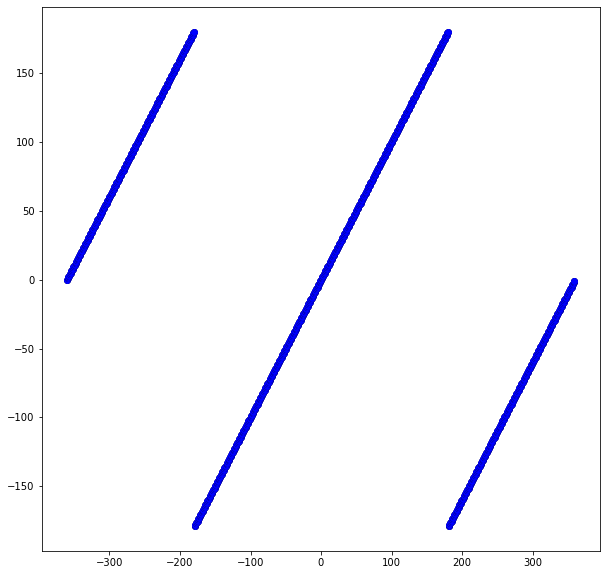

In [ ]:
for angle in range(-360, 360):
    plt.scatter(angle, normalize_angle(angle), c = 'k')
    plt.scatter(angle, normalize_angle_(angle), c = 'b')
plt.show()

In [ ]:
from reward_function import Utils

Utils.normalize_angle( Utils.angle_between_points( (1, 1), (0, 0) ) - 135 ) - -45

135.0

In [ ]:
1/(1 + math.exp(3))

0.04742587317756678

In [ ]:
from scipy import stats

# Find standard deviation so that probability of >15 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)

# Create array of noise based on normal distribution
resample_size = 100000
steering_noise = np.random.normal(0,steering_sd,resample_size)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# all_actions is a DataFrame with 2 columns: speed and steering
X = all_actions

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)

# K-Means Clustering
n_clusters = 19
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Interpretable Centroids will represent the action space
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = X_minmax_fit.inverse_transform(model.cluster_centers_)

NameError: name 'all_actions' is not defined

In [ ]:
calc_distance(center_line[0], center_line[1])

0.1300000000000012

In [66]:
0.25*7.5

1.875

In [65]:
2.5*0.75

1.875

In [68]:
0.25*2

0.5